# Analysis of cBioPortal Data

## CONTENT:

- 1 -> test of the REST API 
- 2 -> transforming JSON objects to dataframes
- 3 -> loading and wrangling the clinical data from all studies
- 4 -> clustering of studies based on attributes (simple version just based on attribute names not values)
- 5 -> similarity scoring function (in future it would normalize the attributes based on their values not just names)
- 6 -> examples of similarity score on different studies

### 1. Getting the raw data from REST API

In [19]:
s = HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_stderr').hide()
 } else {
 $('div.input').show();
 $('div.output_stderr').show()
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for these plots and tables are by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

s

In [18]:
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
from IPython.display import display, HTML



pd.read_json('http://cbioportal-rc.herokuapp.com/api/studies/blca_plasmacytoid_mskcc_2016/clinical-data?projection=SUMMARY&pageNumber=0&pageSize=1000&direction=ASC').head(10)

,clinicalAttributeId,entityId,value
0,CANCER_TYPE,s_DS_sig_054_P,Bladder Cancer
1,CANCER_TYPE_DETAILED,s_DS_sig_054_P,Bladder Urothelial Carcinoma
2,GENE_PANEL,s_DS_sig_054_P,IMPACT341
3,ONCOTREE_CODE,s_DS_sig_054_P,BLCA
4,SAMPLE_CLASS,s_DS_sig_054_P,Tumor
5,SAMPLE_TYPE,s_DS_sig_054_P,Primary
6,SPECIMEN_PRESERVATION_TYPE,s_DS_sig_054_P,FFPE
7,CANCER_TYPE,DS-sig-040-P3,Bladder Cancer
8,CANCER_TYPE_DETAILED,DS-sig-040-P3,Bladder Urothelial Carcinoma
9,GENE_PANEL,DS-sig-040-P3,IMPACT410


### 2. Transformation from raw JSON format to a DataFrame

In [2]:
def json_to_df(df : pd.DataFrame):
    # get the unique entities - study subjects
    # sometimes (1/50) studies aren't formatted like this, so just ignore it for now
    try:
        unique_ids = set(df.entityId)
        unique_attrib = set(df.clinicalAttributeId)
    except AttributeError:
        print('-->failed',end=' ')
        return None
    # get unique attributes - attributes in this study
    # create a dataframe from (study subjects x attributes)
    new_df = pd.DataFrame(index = unique_ids, columns = unique_attrib)
    # go through every id
    for i in unique_ids:
        # get the attribute value
        for j in unique_attrib:
            try:
                # extract value
                value = df.loc[(df['entityId']== i)&(df['clinicalAttributeId'] == j)]
                # set the value in dataframe
                new_df.set_value(index = i, col = j, value = value.values[0,2])
            # in case the value isn't there which is quite often
            except IndexError:
                pass
    return new_df



### 3. Reading all the studies (approx. 145) so this takes around 2 minutes

In [3]:
studies = []  # contains the actual dataframe of studies
study_attributes = []   # contains tuples in form (study_name, [list of attributes])
file = open("all_studies.txt",'r').readlines()

for study in file:   # go through every study
    study = study.strip('\n')   # formating
    print(study,end=' ')         # keep it in check
    string = 'http://cbioportal-rc.herokuapp.com/api/studies/'+study+'/clinical-data?projection=SUMMARY&pageNumber=0&pageSize=1000&direction=ASC'
    df = json_to_df(pd.read_json(string))   # create the dataframe
    if df is not None:              
        studies.append(df)                  # append the dataframe to dataframes
        study_attributes.append((study,df.columns.tolist()))        # append

acbc_mskcc_2015 acc_tcga acyc_fmi_2014 acyc_mda_2015 acyc_mskcc_2013 acyc_sanger_2013 all_stjude_2013 all_stjude_2015 blca_bgi blca_dfarber_mskcc_2014 blca_mskcc_solit_2012 blca_mskcc_solit_2014 blca_plasmacytoid_mskcc_2016 blca_tcga blca_tcga_pub brca_bccrc brca_bccrc_xenograft_2014 brca_broad brca_metabric brca_sanger brca_tcga brca_tcga_pub brca_tcga_pub2015 ccrcc_irc_2014 ccrcc_utokyo_2013 cellline_ccle_broad cellline_nci60 cesc_tcga chol_jhu_2013 chol_nccs_2013 chol_nus_2012 chol_tcga cll_iuopa_2015 coadread_dfci_2016 coadread_genentech coadread_mskcc coadread_tcga coadread_tcga_pub cscc_dfarber_2015 ctcl_columbia_2015 desm_broad_2015 dlbc_broad_2012 dlbc_tcga egc_tmucih_2015 es_dfarber_broad_2014 es_iocurie_2014 esca_broad esca_tcga escc_icgc escc_ucla_2014 gbc_shanghai_2014 gbm_tcga gbm_tcga_pub gbm_tcga_pub2013 hnc_mskcc_2016 hnsc_broad hnsc_jhu hnsc_mdanderson_2013 hnsc_tcga hnsc_tcga_pub kich_tcga kich_tcga_pub kirc_bgi kirc_tcga kirc_tcga_pub kirp_tcga laml_tcga laml_tcga_pu

#### 3.2 Some data wrangling

In [25]:
############################
studies_limit = 140  #######
###########################

### here we need to go from tuple (study,[attr1,attr2...attrN]) into ->  N tuples of (study,attrM)
study_attribute = []
for i in study_attributes[0:studies_limit]:
    for j in i[1]:
        study_attribute.append((i[0],j))

# now we will build the dataframe from a list of tuples        
df = pd.DataFrame.from_records(study_attribute, columns = ['study','attrib'])

# this method is also popular in machine learning, it creates vectors from cateogrical data
# it is like the bag of words model
df2 = pd.get_dummies(df['attrib'])

# we have to re-add the study name
df3 = pd.concat([df['study'], df2], axis=1)

# we need to merge the vectors with the same study names
df3 = df3.groupby('study').sum()

# now drop the attributes who in total are present in less than 5 studies
df3.drop([col for col, val in df3.sum().iteritems() if val < 3], axis=1, inplace=True)

### 4. Clustering
    -> as we used the bag of words model, each study is now represented as a vector of it's study attributes
    -> the best way to compare such vectors is with cosine similarity 
    -> then we have to decide on linkage method, 
    and there are 3:

    - a) average linkage between clusters
    - b) single linkage between clusters
    - c) wighted linkage between clusters

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


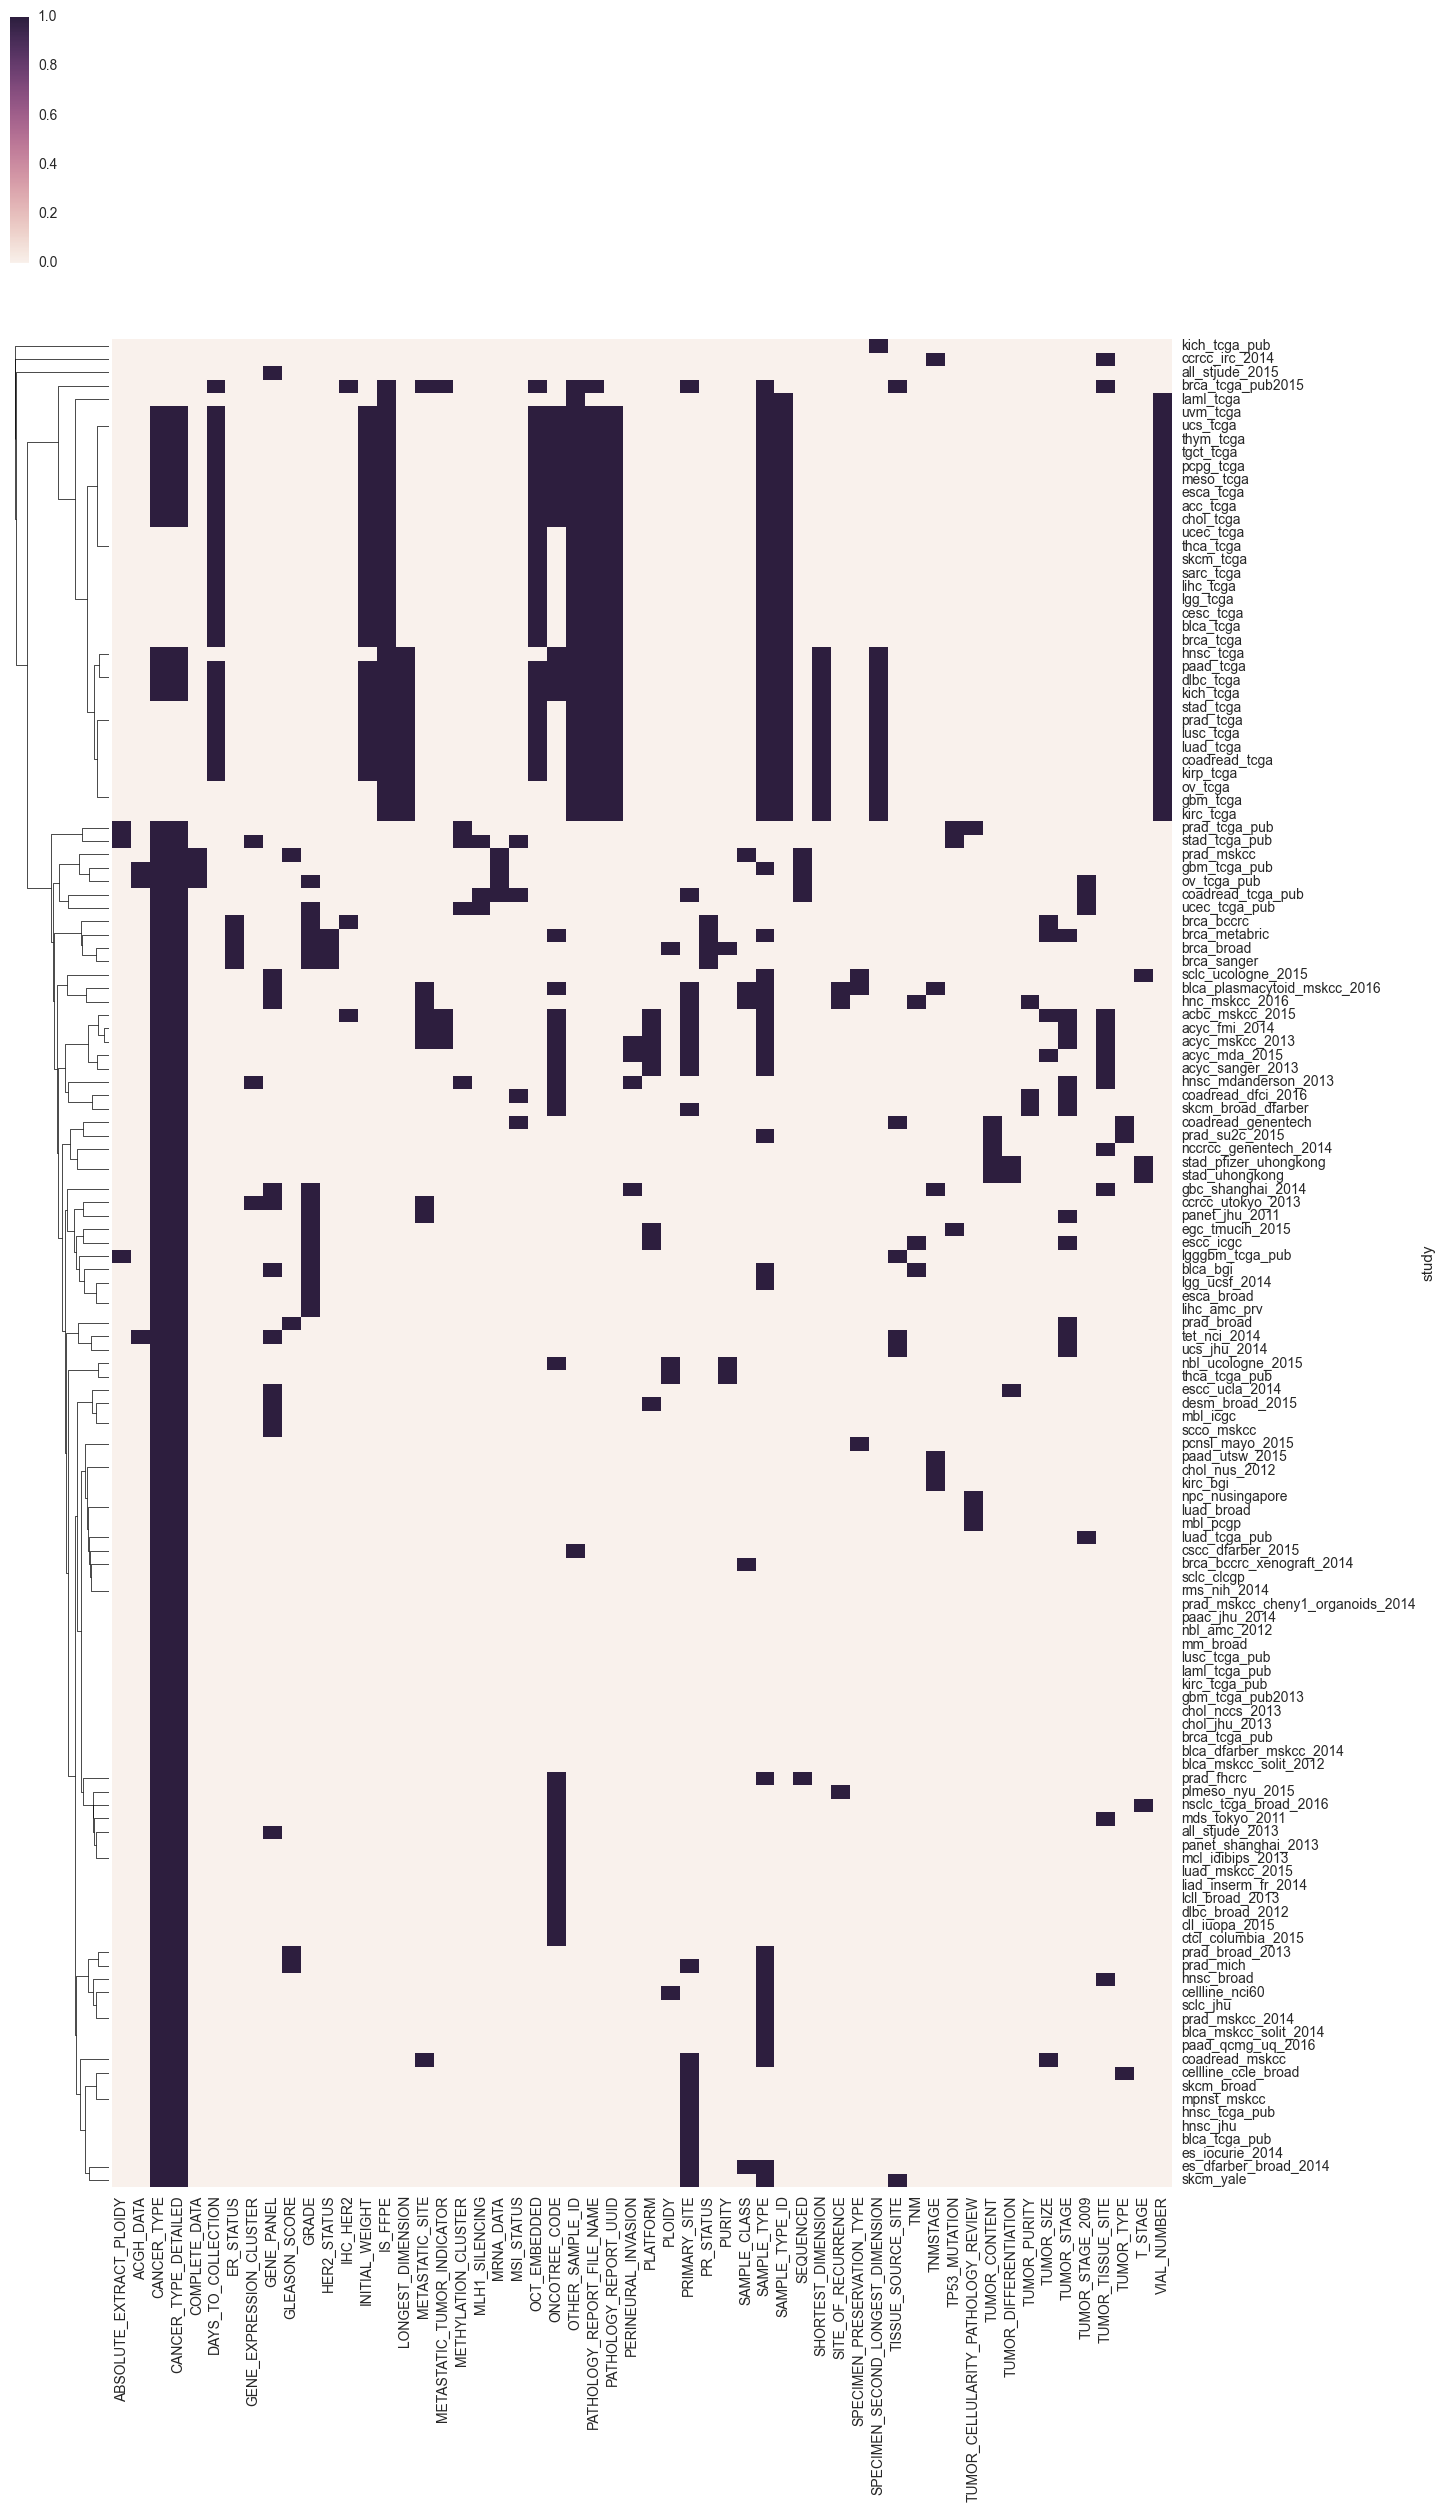

In [26]:
sns.clustermap(df3, method='average', metric = 'cosine', col_cluster=False, figsize=(15, 28))

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


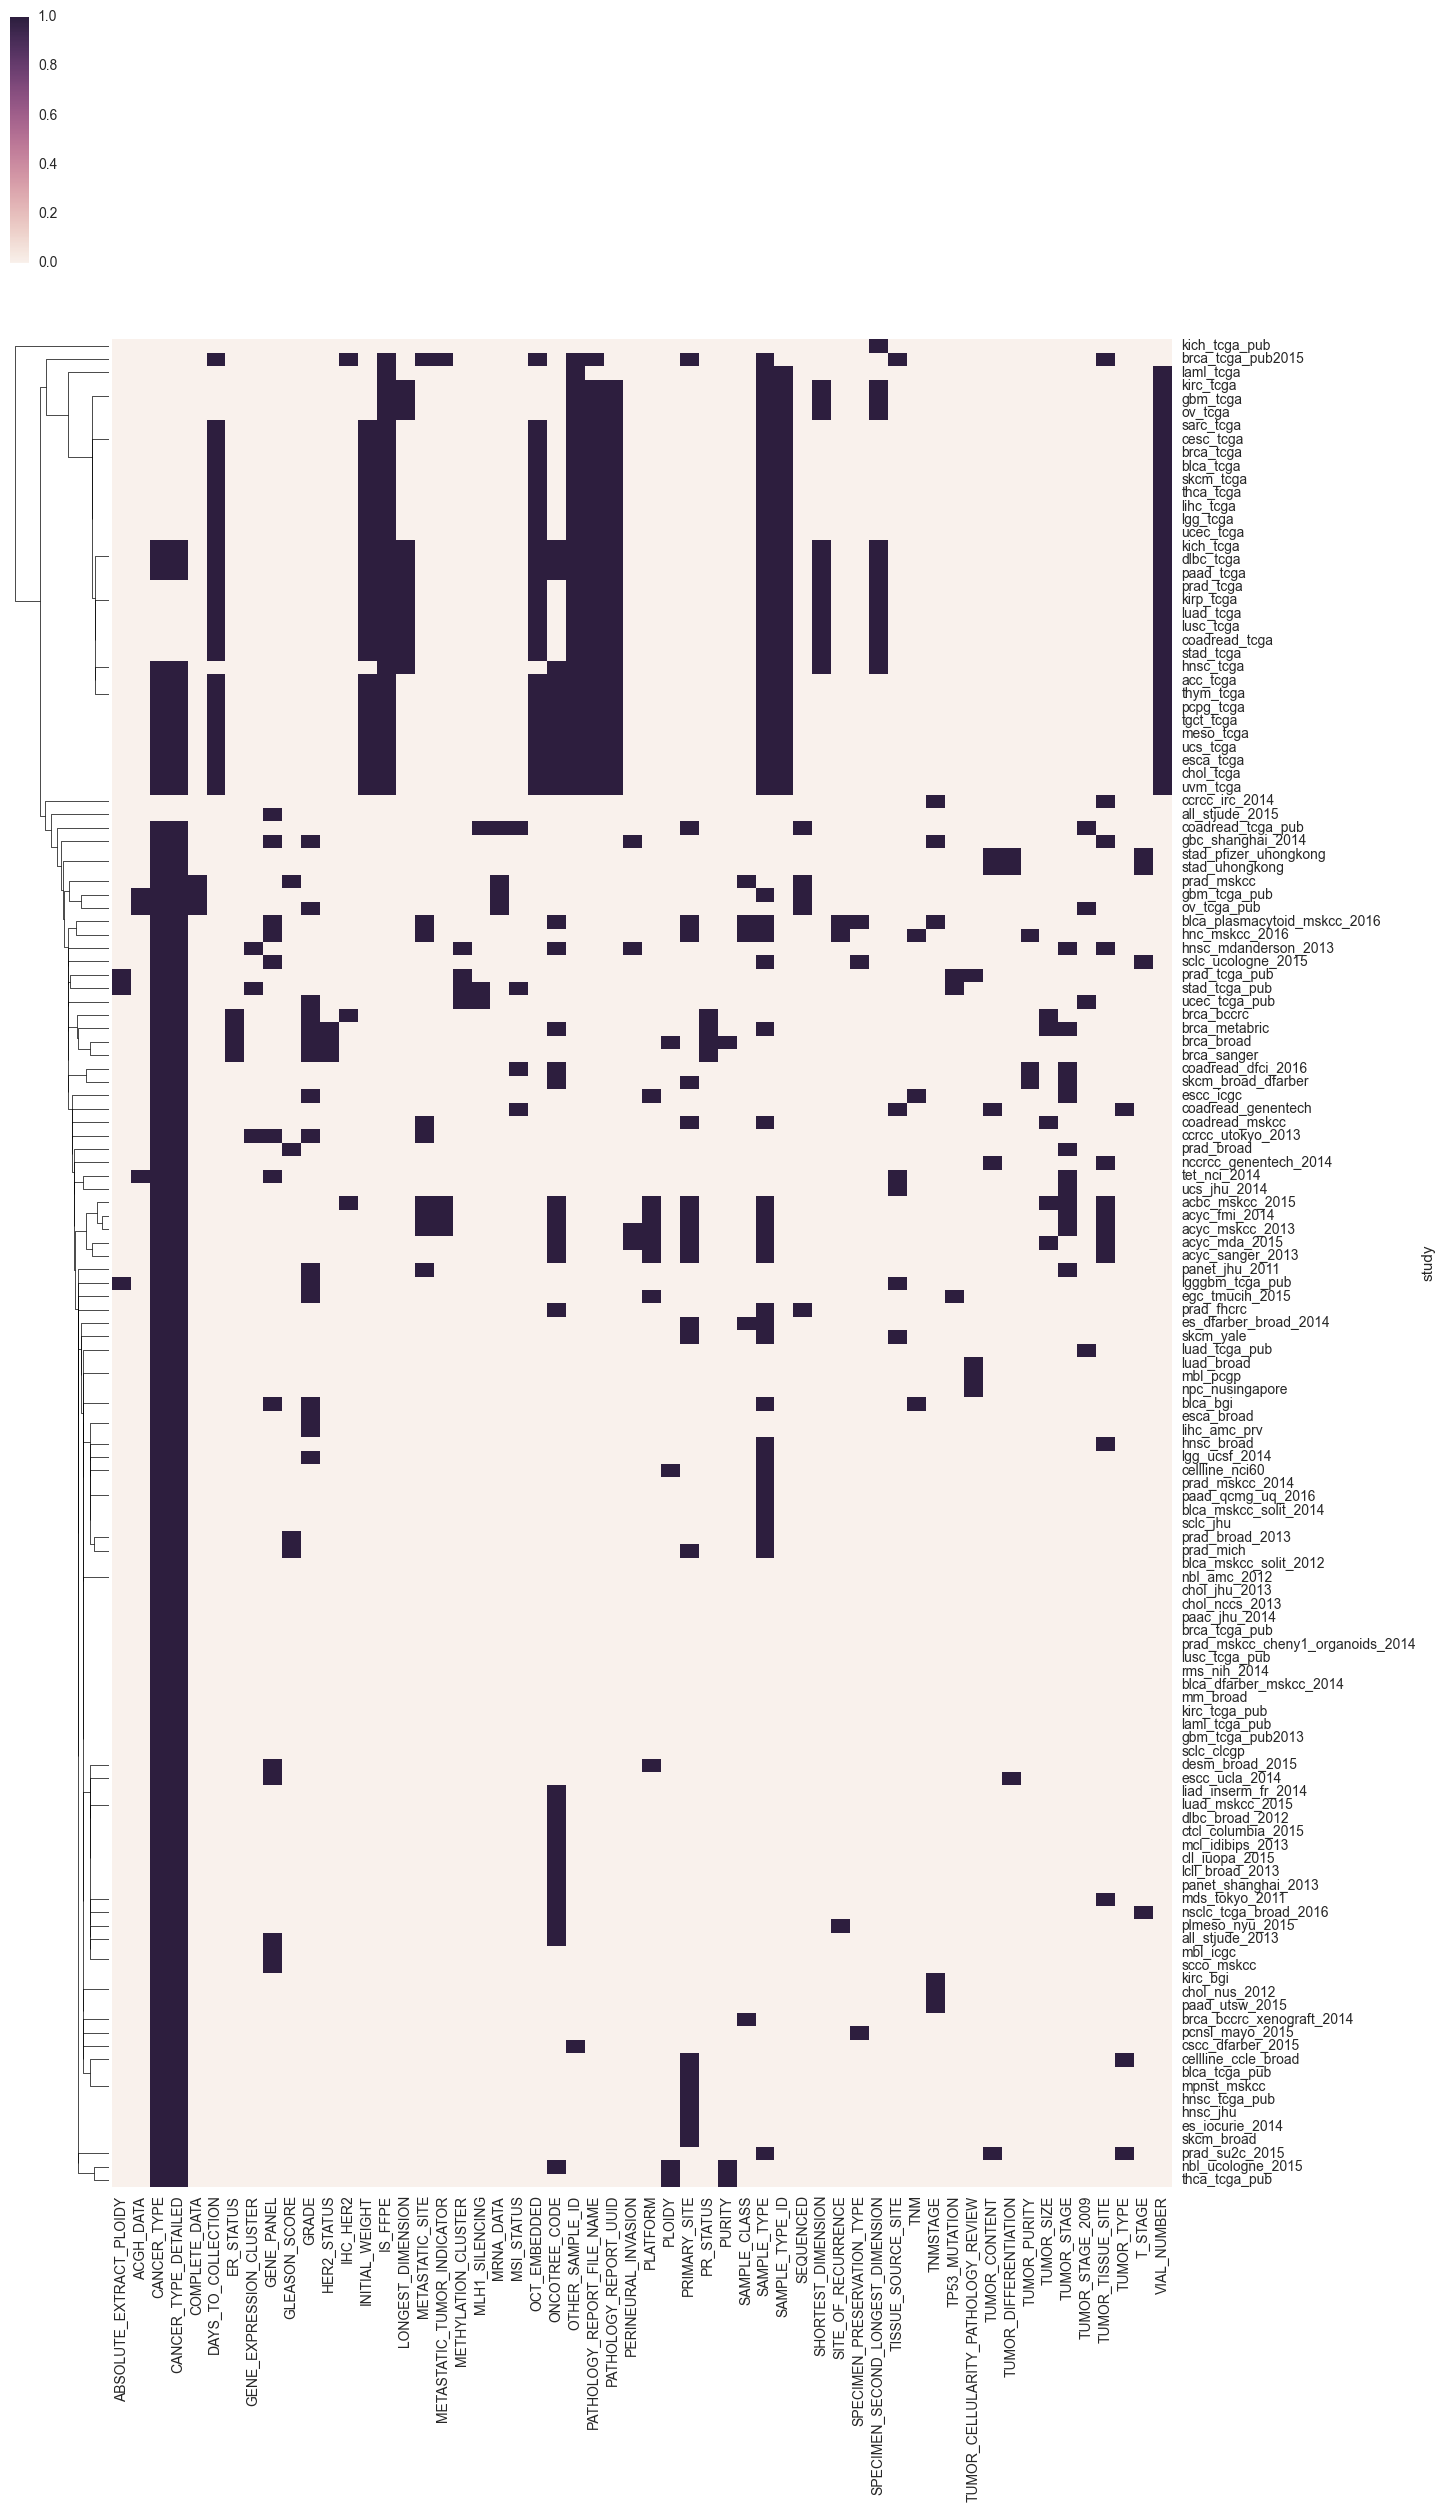

In [27]:
sns.clustermap(df3, method='single', metric = 'cosine', col_cluster=False, figsize=(15, 28))


//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


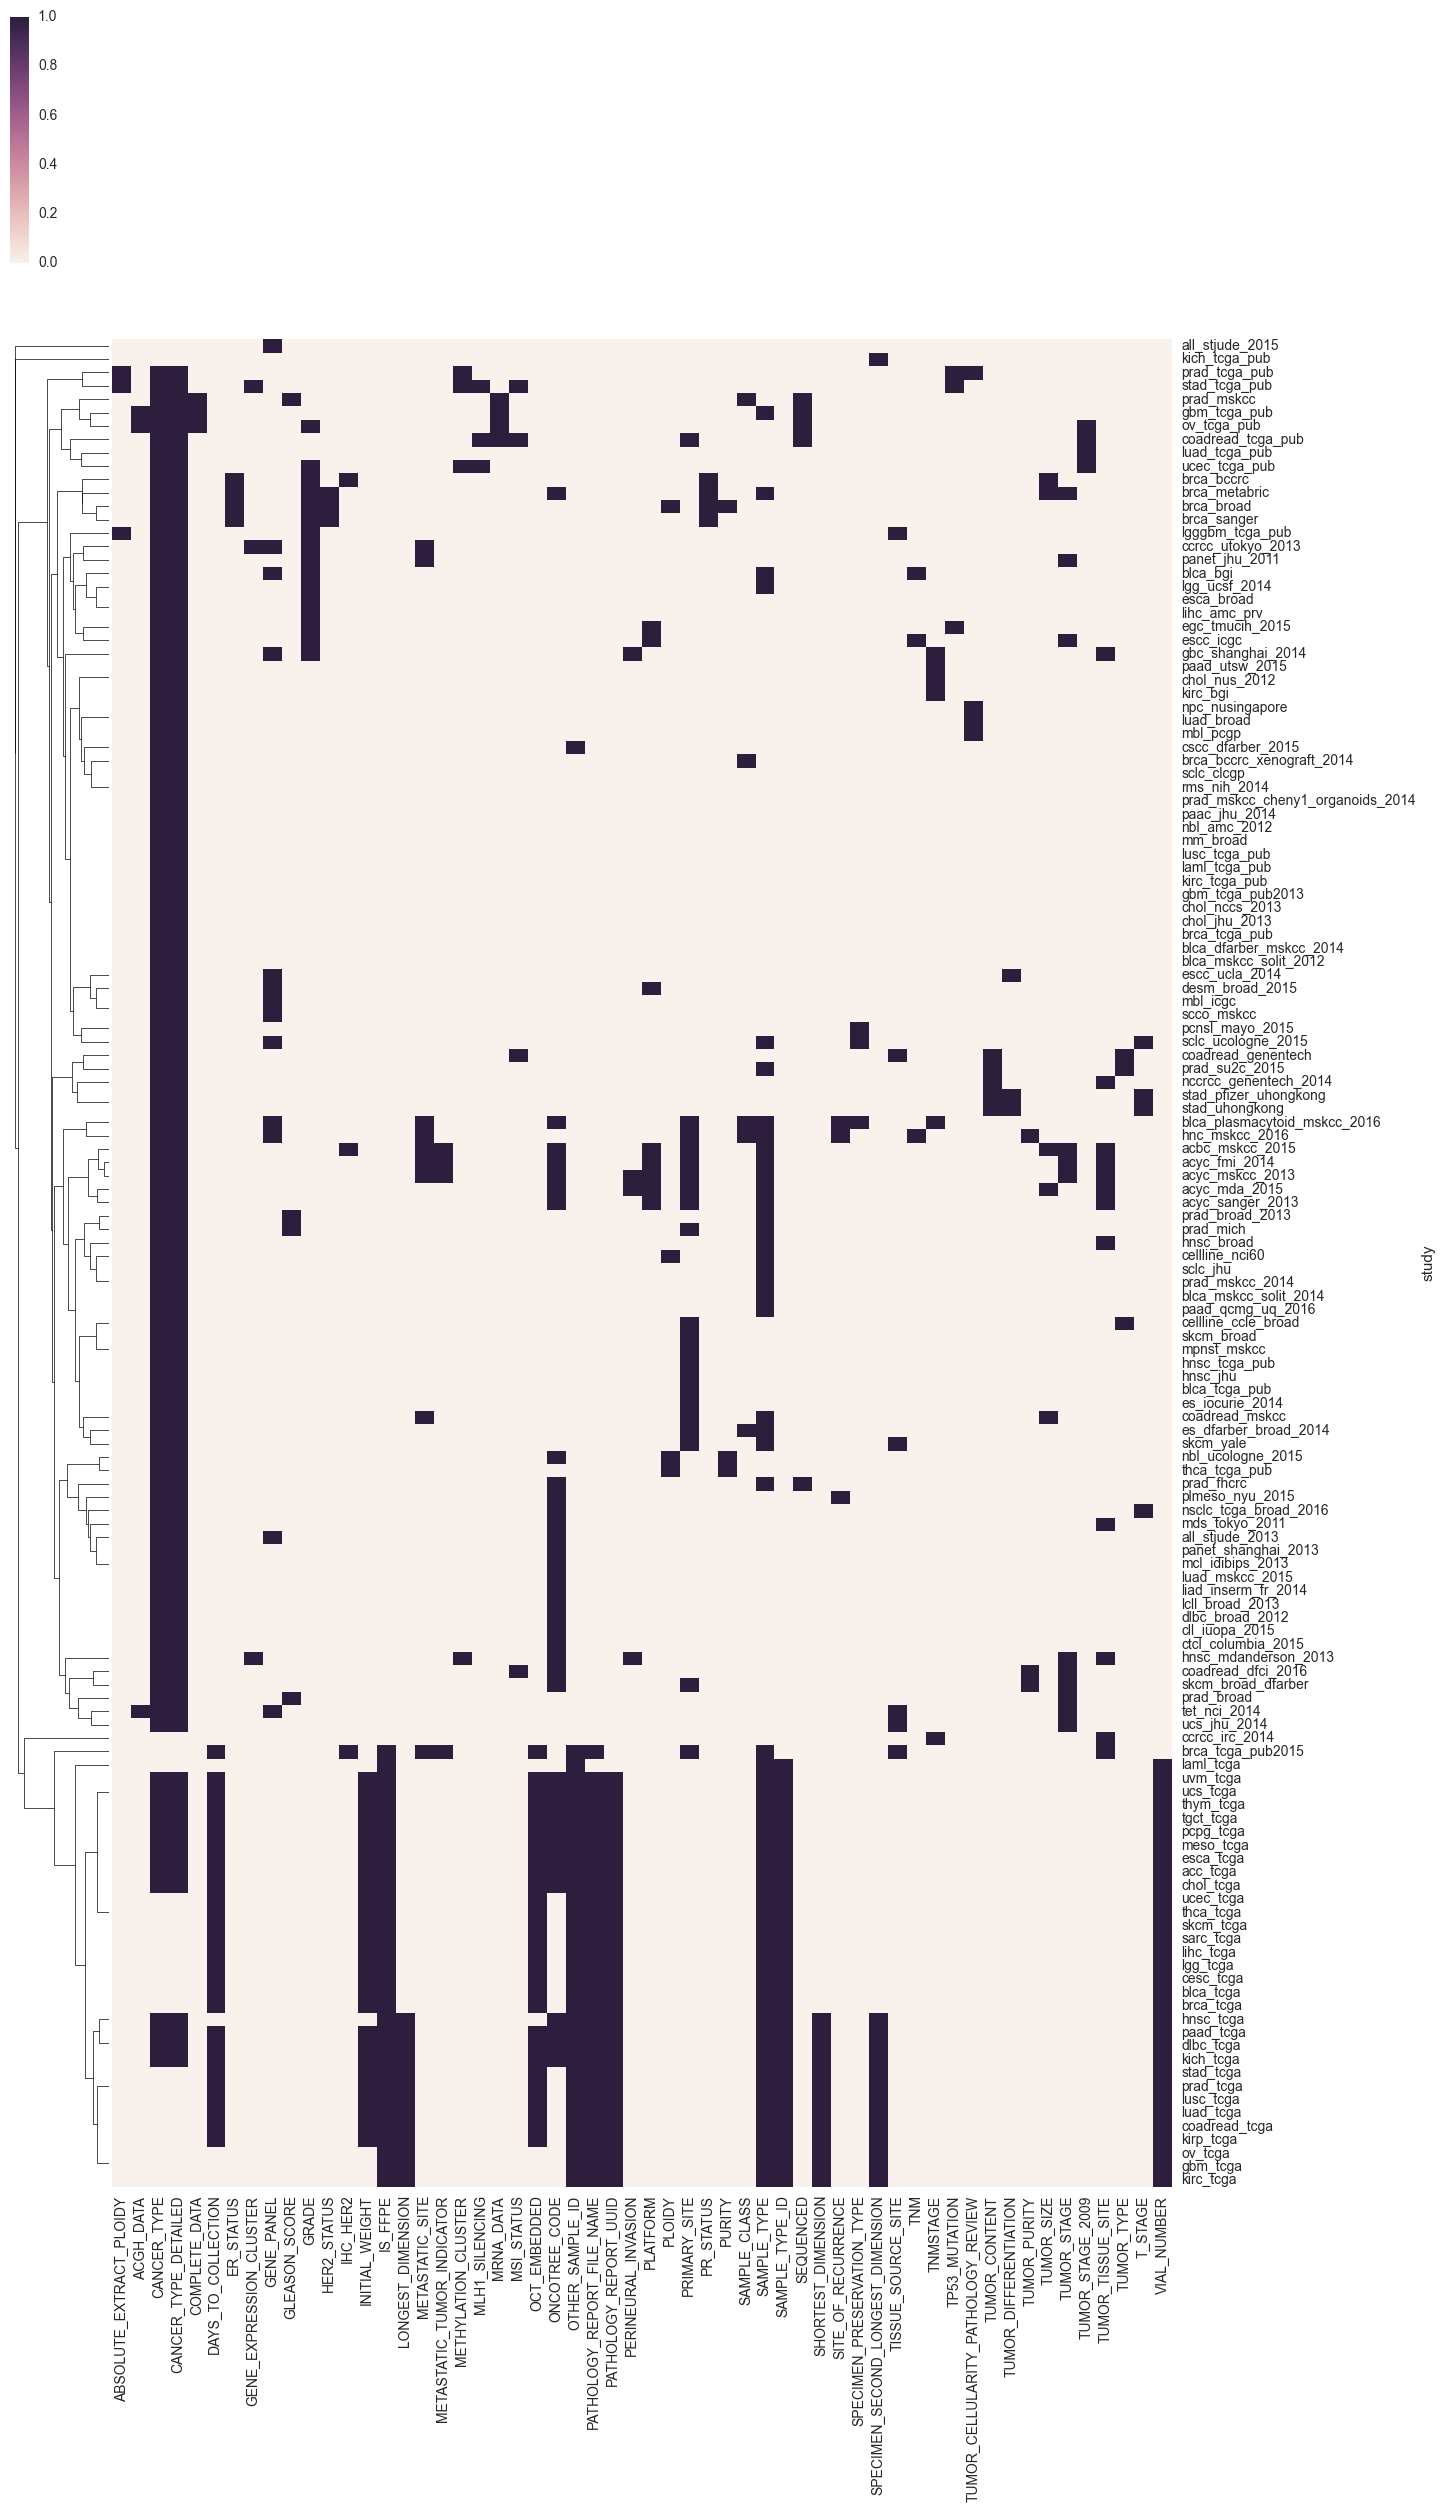

In [28]:
sns.clustermap(df3, method='weighted', metric = 'cosine', col_cluster=False, figsize=(15, 28))

### 5. Similarity scoring functionality I am working on
#### The score consists of:
    - 1. Jaccard coefficient of distinct values of attributes
    - 2. Cosine similarity of attrbutes values vectors
    - 3. Number of same attributes

####  1. Jaccard, Cosing and simple similarity between study attributes

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter



def similarity(df1, df2):
    # get the unique attributes
    study1_attrs=set(df1.columns.values)
    study2_attrs=set(df2.columns.values)

    
    #########################
    # JACCARD COEFFICIENT   #
    #########################
    
    # create a dataframe of desired dimension
    jaccard = pd.DataFrame(index=study1_attrs, columns=study2_attrs)
    jaccard = jaccard.fillna(0.0)

    df1 = df1.reset_index()
    df2 = df2.reset_index()

    
    # loop over unique values by column per dataframe
    # first go over unique values in dataframe1 columns
    for i in study1_attrs:
        unique_vals_1 = set(df1[i].unique())
        # then go over unique values in dataframe2 columns
        for j in study2_attrs:
            # get unique vals for dataframe2
            unique_vals_2 = set(df2[j].unique())
            # get the cardinality
            intersection_cardinality = float(len(set.intersection(unique_vals_1,unique_vals_2)))
            union_cardinality = float(len(set.union(unique_vals_1,unique_vals_2)))
            # jaccard coefficient
            jaccard_coef = float(intersection_cardinality/union_cardinality)
            # set the value into pandas dataframe
            jaccard.set_value(i, j, jaccard_coef)

    # if you print 'df' you can actually get the jaccard coefficient between each column per study
    
    #########################
    # COSINE SIMILARITY   #
    #########################
    
    cosine = pd.DataFrame(index=study1_attrs, columns=study2_attrs)
    cosine = cosine.fillna(0.0)
    
    df1 = df1.reset_index()
    df2 = df2.reset_index()


    for i in study1_attrs:
        # get all values for dataframe1 column i
        values_1 = df1[i].values.astype('str').tolist()
        # get counts per value values for dataframe1
        a_vals = Counter(values_1)

        # then go over values in dataframe2 columns
        for j in study2_attrs:
            # get all values for dataframe2 column j
            values_2 = df2[j].values.astype('str').tolist()            
            # count word occurrences
            b_vals = Counter(values_2)

            # convert to word-vectors
            words  = list(a_vals.keys() | b_vals.keys())
            a_vect = [a_vals.get(word, 0) for word in words]       
            b_vect = [b_vals.get(word, 0) for word in words]       

            # find cosine
            # length of each vector
            len_a  = sum(av*av for av in a_vect) ** 0.5           
            len_b  = sum(bv*bv for bv in b_vect) ** 0.5          
            # dot product of vectors
            dot    = sum(av*bv for av,bv in zip(a_vect, b_vect)) 
            # get the score
            cosine_score = dot / (len_a * len_b)
            # set the value in the place where we track it
            cosine.set_value(i, j, cosine_score)


    # now format the presentation of similar attributes by jaccard
    similar_attributes_value_jacardi = ''
    for i in (jaccard.index.values):
        for j in (jaccard.columns.values):
            if(jaccard.get_value(i,j) > 0.5):
                similar_attributes_value_jacardi += (i +' and ' + j + ' with Jacardi coef = ' + str(jaccard.get_value(i,j)) + ', ')


    # now format the presentation of similar attributes by jaccard
    similar_attributes_value_cosine = ''
    for i in (cosine.index.values):
        for j in (cosine.columns.values):
            if(cosine.get_value(i,j) > 0.5):
                similar_attributes_value_cosine += (i +' and ' + j + ' with Cosine score = ' + str(cosine.get_value(i,j)) + ', ')

    
    
    # get the same named columns
    same_attributes = study1_attrs.intersection(study2_attrs)
    # these are unique attributes in each study
    unique_attrs_study1 = study1_attrs-same_attributes
    unique_attrs_study2 = study2_attrs-same_attributes
                
    print("Study1 attributes:", study1_attrs)
    print("-----------------------------------------------------------------------------------------")
    print("Study2 attributes:", study2_attrs)
    print("-----------------------------------------------------------------------------------------")
    print("Same attributesin both studies:",same_attributes)
    print("-----------------------------------------------------------------------------------------")
    print("Similar attributes based on Jaccardi coefficient:",similar_attributes_value_jacardi)
    print("-----------------------------------------------------------------------------------------")
    print("Similar attributes based on Cosine score:",similar_attributes_value_cosine)


    return 


### 6. Examples of similarity score

In [19]:
similarity(studies[1],studies[5])

Study1 attributes: {'CANCER_TYPE_DETAILED', 'OCT_EMBEDDED', 'CANCER_TYPE', 'SAMPLE_TYPE_ID', 'VIAL_NUMBER', 'PATHOLOGY_REPORT_UUID', 'DAYS_TO_COLLECTION', 'IS_FFPE', 'OTHER_SAMPLE_ID', 'INITIAL_WEIGHT', 'ONCOTREE_CODE', 'PATHOLOGY_REPORT_FILE_NAME', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Study2 attributes: {'PRIMARY_SITE', 'CANCER_TYPE_DETAILED', 'PLATFORM', 'TUMOR_TISSUE_SITE', 'CANCER_TYPE', 'ONCOTREE_CODE', 'ABERRANT_CELL_FRACTION', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Same attributesin both studies: {'ONCOTREE_CODE', 'CANCER_TYPE_DETAILED', 'CANCER_TYPE', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Similar attributes based on Jaccardi coefficient: 
-----------------------------------------------------------------------------------------
Similar attributes based on Cosine score: 


In [20]:
similarity(studies[2],studies[11])

Study1 attributes: {'PRIMARY_SITE', 'CANCER_TYPE_DETAILED', 'METASTATIC_TUMOR_INDICATOR', 'PLATFORM', 'TUMOR_TISSUE_SITE', 'CANCER_TYPE', 'METASTATIC_SITE', 'ONCOTREE_CODE', 'TUMOR_STAGE', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Study2 attributes: {'CONCOMITANT_CIS', 'CANCER_TYPE_DETAILED', 'TISSUE_SEQUENCED', 'CANCER_TYPE', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Same attributesin both studies: {'CANCER_TYPE_DETAILED', 'CANCER_TYPE', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Similar attributes based on Jaccardi coefficient: METASTATIC_TUMOR_INDICATOR and CONCOMITANT_CIS with Jacardi coef = 1.0, 
-----------------------------------------------------------------------------------------
Similar attributes based on Cosine score: METASTATIC_TUMOR_INDICATOR and CONCOMITANT_CIS with Cosine score = 0.96

In [21]:
similarity(studies[22],studies[35])

Study1 attributes: {'SAMPLE_TYPE', 'HER2_POSITIVITY_SCALE_OTHER', 'TISSUE_SOURCE_SITE', 'METASTATIC_TUMOR_INDICATOR', 'PR_POSITIVITY_SCALE_OTHER', 'HER2_POSITIVITY_METHOD_TEXT', 'PR_POSITIVITY_IHC_INTENSITY_SCORE', 'METASTATIC_SITE', 'IS_FFPE', 'PR_POSITIVITY_DEFINE_METHOD', 'OCT_EMBEDDED', 'ER_STATUS_IHC_PERCENT_POSITIVE', 'DAYS_TO_COLLECTION', 'HER2_AND_CENT17_CELLS_COUNT', 'ER_POSITIVITY_SCALE_OTHER', 'FIRST_SURGICAL_PROCEDURE_OTHER', 'IHC_HER2', 'PR_STATUS_BY_IHC', 'HER2_IHC_PERCENT_POSITIVE', 'MICROMET_DETECTION_BY_IHC', 'HER2_FISH_STATUS', 'PR_POSITIVITY_SCALE_USED', 'SURGICAL_PROCEDURE_FIRST', 'TUMOR_TISSUE_SITE', 'ER_POSITIVITY_SCALE_USED', 'HER2_CENT17_RATIO', 'PR_STATUS_IHC_PERCENT_POSITIVE', 'STAGING_SYSTEM_OTHER', 'OTHER_SAMPLE_ID', 'ER_STATUS_BY_IHC', 'IHC_SCORE', 'PATHOLOGY_REPORT_FILE_NAME', 'HER2_IHC_SCORE', 'HER2_FISH_METHOD', 'PRIMARY_SITE'}
-----------------------------------------------------------------------------------------
Study2 attributes: {'SAMPLE_TYPE', 'CA

In [22]:
similarity(studies[3],studies[18])

Study1 attributes: {'PRIMARY_SITE', 'CANCER_TYPE_DETAILED', 'PLATFORM', 'TUMOR_TISSUE_SITE', 'CANCER_TYPE', 'TUMOR_SIZE', 'PERINEURAL_INVASION', 'ONCOTREE_CODE', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Study2 attributes: {'HER2_STATUS', 'CANCER_TYPE_DETAILED', 'CANCER_TYPE', 'TUMOR_SIZE', 'GRADE', 'ONCOTREE_CODE', 'PR_STATUS', 'ER_STATUS', 'TUMOR_STAGE', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Same attributesin both studies: {'ONCOTREE_CODE', 'CANCER_TYPE_DETAILED', 'TUMOR_SIZE', 'CANCER_TYPE', 'SAMPLE_TYPE'}
-----------------------------------------------------------------------------------------
Similar attributes based on Jaccardi coefficient: SAMPLE_TYPE and SAMPLE_TYPE with Jacardi coef = 1.0, 
-----------------------------------------------------------------------------------------
Similar attributes based on Cosine score: TUMOR_SIZE and GRADE with Cos

In [23]:
similarity(studies[19],studies[54])

Study1 attributes: {'CANCER_TYPE_DETAILED', 'CANCER_TYPE', 'MITOTIC_SCORE', 'GRADE', 'PLEOMORPHISM_SCORE', 'MITOTIC_COUNT', 'TUBULE_SCORE', 'PR_STATUS', 'ER_STATUS', 'ABERRANT_CELL_FRACTION', 'HER2_STATUS'}
-----------------------------------------------------------------------------------------
Study2 attributes: {'SAMPLE_TYPE', 'PRIMARY_SITE', 'CANCER_TYPE_DETAILED', 'SO_COMMENTS', 'CANCER_TYPE', 'DETAILED_METASTATIC_SITE', 'METASTATIC_SITE', 'DISTANT_METS', 'MYB-NFIB_FISH', 'TUMOR_PURITY', 'SITE_OF_RECURRENCE', 'DISTANT_METASTASIS_PATHOLOGIC_SPREAD', 'SAMPLE_COVERAGE', 'GENE_PANEL', 'RUN', 'SAMPLE_CLASS', 'TNM', 'SITE_SEQUENCED'}
-----------------------------------------------------------------------------------------
Same attributesin both studies: {'CANCER_TYPE_DETAILED', 'CANCER_TYPE'}
-----------------------------------------------------------------------------------------
Similar attributes based on Jaccardi coefficient: 
--------------------------------------------------------

# Closing words

List of studies (source):
- https://github.com/cBioPortal/datahub/tree/master/public
    - if needed you could parse the name of studies from the website and feed them into here
    
    
Issues:
- is this the proper REST API usage?
- I can only query 1000 rows at a time 
    - ie. pageSize=1000 parameter